# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500

In [3]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
ticker_list = df_tickers['Symbol'].tolist()

In [5]:
print(f"Number of tickers in the list: {len(ticker_list)}")

Number of tickers in the list: 503


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [6]:
news_dict = {}
for ticker in ticker_list:
    try:
        stock = yf.Ticker(ticker)
        news_dict[ticker] = stock.news
    except Exception as e:
        print(f"Could not get news for {ticker}: {e}")

print(f"Successfully retrieved news for {len(news_dict)} tickers.")

Successfully retrieved news for 503 tickers.


In [7]:
# Printing the first 10 items of the dictionary
for i, (ticker, news_list) in enumerate(news_dict.items()):
    if i >= 10:
        break
    print(f"News for {ticker}: {news_list}")

News for MMM: [{'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'content': {'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'contentType': 'STORY', 'title': '3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer', 'description': '', 'summary': 'We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]', 'pubDate': '2025-07-24T09:03:00Z', 'displayTime': '2025-07-24T09:03:00Z', 'isHosted': True, 'bypassModal': False, 'previewUrl': None, 'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/093e1a4edd0e304bc17c1f522a735210', 'originalWidth': 1000, 'originalHeight': 667, 'caption': '3M Company (MMM): "I Was Surprised" By The Organic Growth Rate, Says Jim Cramer', 'res

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [8]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

news_list = []
for ticker, news_items in news_dict.items():
    for item in news_items:
        # Accessing the content dictionary within each news item
        content = item.get('content')
        if content:
            news_list.append({
                'TICKER': ticker,
                'TITLE': content.get('title', ''),
                'SUMMARY': content.get('summary', ''),
                'PUBLICATION_DATE': content.get('pubDate', ''),
                'URL': content.get('canonicalUrl', {}).get('url', '')
            })
        else:
            print(f"Skipping news item for {ticker} due to missing content.")


news_df = pd.DataFrame(news_list)
display(news_df.head())
print(f"Shape of the news dataframe: {news_df.shape}")

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...


Shape of the news dataframe: (5020, 5)


In [9]:
print(f"Total number of news items in news_list: {len(news_list)}")

Total number of news items in news_list: 5020


In [10]:
apple_news = news_df[news_df['TICKER'] == 'AAPL']
display(apple_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
380,AAPL,"Stock market today: Dow, S&P 500, Nasdaq futur...",US stock futures traded flat as Wall Street pr...,2025-07-28T23:37:20Z,https://finance.yahoo.com/news/live/stock-mark...
381,AAPL,"Microsoft, Meta, Apple, Amazon: How to play Bi...","""Magnificent Seven"" earnings continue with Mic...",2025-07-28T20:18:44Z,https://finance.yahoo.com/video/microsoft-meta...
382,AAPL,EU trade deal: What to expect in markets & ear...,"Stocks (^GSPC,&nbsp;^IXIC,&nbsp;^DJI) are high...",2025-07-28T14:08:40Z,https://finance.yahoo.com/video/eu-trade-deal-...
383,AAPL,"Federal Reserve meeting, July jobs report, and...",The stock market is at record highs as investo...,2025-07-27T11:37:56Z,https://finance.yahoo.com/news/federal-reserve...
384,AAPL,Apple Shift Turns India Into World’s Top Maker...,(Bloomberg) -- India has overtaken China to be...,2025-07-29T01:48:22Z,https://finance.yahoo.com/news/most-phones-sol...
385,AAPL,Google launches AI Mode in the UK amid ‘major ...,The new AI-powered Google Search function allo...,2025-07-28T23:01:00Z,https://uk.finance.yahoo.com/news/google-launc...
386,AAPL,"MSFT, META, AAPL, AMZN: One Chart Stands Above...",4 Magnificent 7 stocks are reporting earnings ...,2025-07-28T22:54:00Z,https://finance.yahoo.com/news/msft-meta-aapl-...
387,AAPL,August: Time to Unplug from Markets?,While stocks continue to print fresh all-time ...,2025-07-28T22:47:00Z,https://finance.yahoo.com/news/august-time-unp...
388,AAPL,Boeing Needs to Show Earnings Progress to Keep...,Boeing reports second-quarter earnings on Tues...,2025-07-28T21:21:00Z,https://www.barrons.com/articles/boeing-earnin...
389,AAPL,"Stocks Hold at Record, Dollar Jumps on Trade H...",(Bloomberg) -- Wall Street traders left stocks...,2025-07-28T20:55:28Z,https://finance.yahoo.com/news/dollar-extends-...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [11]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Loading the pre-trained sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Adding a column to the news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
news_df['EMBEDDED_TEXT'] = news_df['TITLE']

# Adding a column to news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT
news_df['EMBEDDINGS'] = news_df['EMBEDDED_TEXT'].apply(lambda x: model.encode(x))

display(news_df.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455427, -0.109047554, -0.07995972, 0.026..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.0216293, -0.07978322, -0.025434958, 0.0075..."
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...,"Stock Market News for Jul 21, 2025","[-0.037469547, -0.043813713, 0.02352598, 0.107..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.080801524, -0.029800754, -0.03165096, 0.04..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.01950261, -0.07280385, 0.04442304, -0.0564..."


In [12]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TICKER            5020 non-null   object
 1   TITLE             5020 non-null   object
 2   SUMMARY           5020 non-null   object
 3   PUBLICATION_DATE  5020 non-null   object
 4   URL               5020 non-null   object
 5   EMBEDDED_TEXT     5020 non-null   object
 6   EMBEDDINGS        5020 non-null   object
dtypes: object(7)
memory usage: 274.7+ KB


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [13]:
# Converting 'PUBLICATION_DATE' to datetime objects for proper sorting
news_df['PUBLICATION_DATE'] = pd.to_datetime(news_df['PUBLICATION_DATE'], errors='coerce')

# Sorting the news by ticker and then by publication date in descending order
news_df_sorted = news_df.sort_values(by=['TICKER', 'PUBLICATION_DATE'], ascending=[True, False])

# Keeping only one news for each company (ticker) by taking the first (most recent) news item for each group
news_df_unique = news_df_sorted.groupby('TICKER').first().reset_index()

# Displaying the head of the new dataframe and its shape to confirm the simplification
display(news_df_unique.head())
print(f"Shape of the simplified news dataframe: {news_df_unique.shape}")

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,A,Agilent Technologies' Q3 2025 Earnings: What t...,Agilent Technologies is expected to release it...,2025-07-24 12:27:49+00:00,https://www.barchart.com/story/news/33614709/a...,Agilent Technologies' Q3 2025 Earnings: What t...,"[-0.04857133, 0.040652923, -0.011258363, 0.017..."
1,AAPL,Apple Shift Turns India Into World’s Top Maker...,(Bloomberg) -- India has overtaken China to be...,2025-07-29 01:48:22+00:00,https://finance.yahoo.com/news/most-phones-sol...,Apple Shift Turns India Into World’s Top Maker...,"[-0.06271256, -0.046261813, 0.047562163, -0.01..."
2,ABBV,HS market forecast to reach $7.8bn across 7MM ...,This 15.6% CAGR is largely attributed to the l...,2025-07-28 17:09:44+00:00,https://www.pharmaceutical-technology.com/anal...,HS market forecast to reach $7.8bn across 7MM ...,"[-0.012529854, -0.025249073, 0.043373175, 0.08..."
3,ABNB,‘I Prep for Survival’: OpenAI CEO Sam Altman W...,Sam Altman’s reflections on global risk unders...,2025-07-28 13:53:13+00:00,https://www.barchart.com/story/news/33685851/i...,‘I Prep for Survival’: OpenAI CEO Sam Altman W...,"[-0.009871567, -0.05959456, -0.024678018, -0.0..."
4,ABT,Revvity trims 2025 profit forecast as China po...,(Reuters) -Revvity on Monday lowered its full-...,2025-07-28 12:09:43+00:00,https://finance.yahoo.com/news/revvity-trims-2...,Revvity trims 2025 profit forecast as China po...,"[0.00020876588, -0.009514624, 0.111798786, 0.0..."


Shape of the simplified news dataframe: (502, 7)


In [14]:
news_df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   TICKER            502 non-null    object             
 1   TITLE             502 non-null    object             
 2   SUMMARY           502 non-null    object             
 3   PUBLICATION_DATE  502 non-null    datetime64[ns, UTC]
 4   URL               502 non-null    object             
 5   EMBEDDED_TEXT     502 non-null    object             
 6   EMBEDDINGS        502 non-null    object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 27.6+ KB


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [15]:
# Extracting the embeddings for clustering
embeddings = news_df_unique['EMBEDDINGS'].tolist()

# Initializing lists to store silhouette scores and k values
silhouette_scores = []
k_values = range(2, 7)

# Performing K-Means clustering and compute silhouette scores for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k}: {score}")

Silhouette score for k=2: 0.05178447812795639
Silhouette score for k=3: 0.05498514696955681
Silhouette score for k=4: 0.02927619218826294
Silhouette score for k=5: 0.03379878029227257
Silhouette score for k=6: 0.02860766090452671


#### Plot silhouette scores

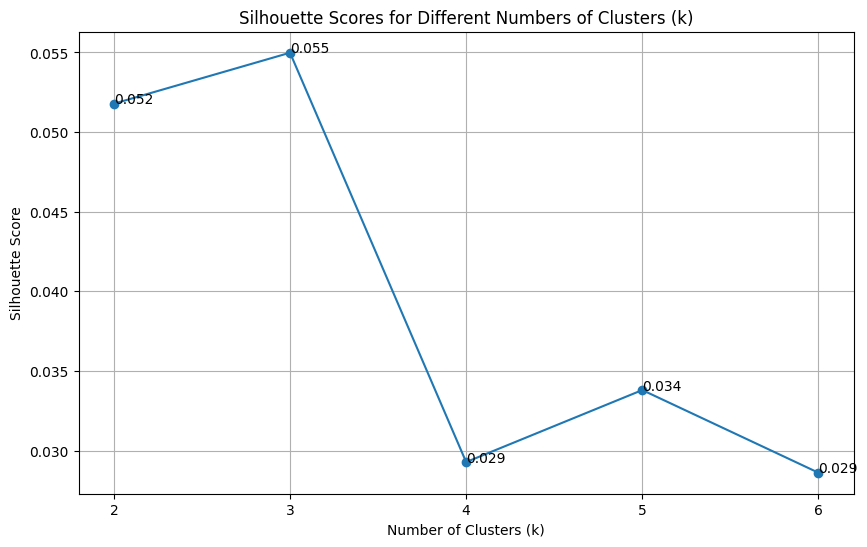

In [16]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

# Adding the silhouette score values to each point
for i, score in enumerate(silhouette_scores):
    plt.text(k_values[i], score, f'{score:.3f}')

plt.show()

#### Identify the Best k

In [17]:
# Finding the k value with the highest silhouette score
best_k_index = silhouette_scores.index(max(silhouette_scores))
best_k = k_values[best_k_index]

print(f"The best number of clusters (k) based on silhouette score is: {best_k}")

The best number of clusters (k) based on silhouette score is: 3


#### Cluster the embeddings using 3 clusters (k=3)

In [18]:
# Cluster the embeddings using k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(embeddings)

KMeans(n_clusters=3, n_init=10, random_state=42)

### Visualize the 2 first PCA Components of your embeddings

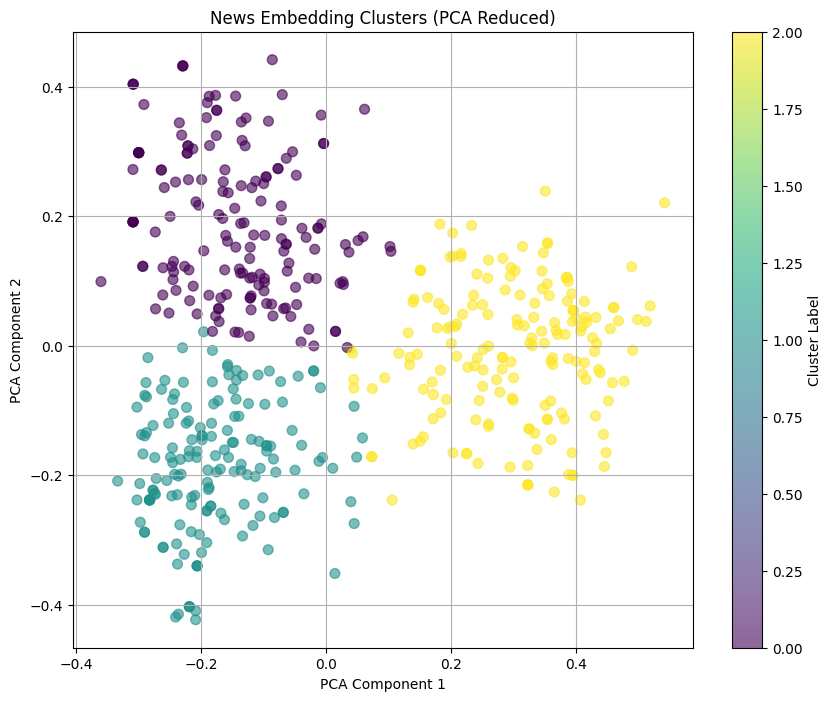

In [19]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Creating a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PCA Component 1', 'PCA Component 2'])

# Adding the cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans.labels_

# Visualizing the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PCA Component 1'], pca_df['PCA Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.title('News Embedding Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [20]:
# Adding the kmeans cluster label to news dataframe
news_df_unique['Cluster_Label'] = kmeans.labels_

# Printing the content of each cluster and analyze it
for cluster_id in sorted(news_df_unique['Cluster_Label'].unique()):
    print(f"--- Cluster {cluster_id} ---")
    cluster_news = news_df_unique[news_df_unique['Cluster_Label'] == cluster_id]
    # Displaying a few sample news titles and summaries from the cluster
    for index, row in cluster_news.head(5).iterrows():
        print(f" Ticker: {row['TICKER']}")
        print(f" Title: {row['TITLE']}")
        print(f" Summary: {row['SUMMARY']}")
        print("-" * 20)
    print("\n")

--- Cluster 0 ---
 Ticker: AAPL
 Title: Apple Shift Turns India Into World’s Top Maker of US Smartphones
 Summary: (Bloomberg) -- India has overtaken China to become the top source of smartphones sold in the US, after Apple Inc. shifted to assemble more of its iPhones in the South Asian country.Most Read from BloombergBudapest’s Most Historic Site Gets a Controversial RebuildSan Francisco in Talks With Vanderbilt for Downtown CampusCan This Bridge Ease the Troubled US-Canadian Relationship?Trump Administration Sues NYC Over Sanctuary City PolicyIn the quarter through June, India was the largest manufacturer
--------------------
 Ticker: ABBV
 Title: HS market forecast to reach $7.8bn across 7MM by 2034
 Summary: This 15.6% CAGR is largely attributed to the launch of novel biologics and small molecules.
--------------------
 Ticker: ABNB
 Title: ‘I Prep for Survival’: OpenAI CEO Sam Altman Worries About The ‘Nonzero’ Chance The World Will End From ‘a Lethal Synthetic Virus’
 Summary: Sa



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

YOUR WRITTEN RESPONSE HERE

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

YOUR WRITTEN RESPONSE HERE

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

YOUR WRITTEN RESPONSE HERE


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

YOUR WRITTEN RESPONSE

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

YOUR WRITTEN RESPONSE

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

YOUR WRITTEN RESPONSE

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

YOUR WRITTEN RESPONSE

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

YOUR WRITTEN RESPONSE

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

YOUR WRITTEN RESPONSE

---

#### 1️⃣0️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

YOU WRITTEN RESPONSE



# Task
Analyze news headlines for 500 stocks using text embeddings and K-Means clustering to identify common themes and visualize the clusters. Determine the optimal number of clusters using the silhouette score and reduce dimensionality for visualization using PCA. Finally, analyze the content of each cluster and answer questions about the findings.

## Generate text embeddings

### Subtask:
Load the pre-trained sentence transformer model and create embeddings for the news titles in the DataFrame.


### Responses

 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

Using a smaller model like MiniLM is faster and uses less memory, never the less, it might capture less semantic meaning, leading to less distinct clusters with potentially broader interpretations (as seen with the low silhouette scores, where all of them are pretty close to 0 indicanting they are not been clearly separated). Larger transformer models, especially in finance domain, could capture richer semantic details, potentially resulting in better-separated, more granular, and meaningful clusters, but at a higher computational cost.

2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

Using only titles gives concise embeddings, potentially lacking context; summaries provide richer detail for more semantic clusters; combining them offers a balance.
####How could you empirically test this?
Utilizing only titles might lack sufficient context;summaries could provide greater detail. I believe a combination of both would offer a more comprehensive and balanced context. To test this empirically, I would suggest creating embeddings for both the titles and the descriptions, then combining them.
Subsequently, we could compare the results using the silhouette score of the clusters to determine which approach performs better.

 3️⃣ PCA seeks to reduce dimensionality by projecting data onto the components that maximize overall variance. That is, it focuses on preserving the overall distances between points in the original space. t-SNE and UMAP are nonlinear methods that prioritize preserving local structure and neighborhood relationships between points in the reduced space. They are preferable to PCA for visualization when the primary goal is to reveal the structure of clusters, subgroups, or local continuity in the data, as they can often better separate clusters that are intermixed in a linear PCA projection, although at the expense of preserving overall distances.

 4️⃣ Based on the analysis and the low silhouette scores, a key challenge is the lack of clear separation between clusters, making it difficult to define precise boundaries. One strategy is to test other clustering algorithms or improve embeddings using more finance-specific models. Another challenge is assigning a coherent theme to each cluster, as the content can be varied. Addressing this could involve deeper text analysis within each cluster or adjusting the number of clusters.

 5️⃣ Visually, in the 2D PCA plot, we cannot observe outliers that are extremely distant from all groups, although some points are more dispersed within or between clusters. To identify them more rigorously in the original embedding space, other methods could be used to help identify the "noise."

6️⃣ Based on the examples, it appears that Cluster 0 is focused on stock/investment analysis; Cluster 1 appears to focus on earnings/financial results of specific companies. In contrast, Cluster 2 appears to be more general, covering broad market news, technology, and various corporate events.
My confidence would be moderate due to the low silhouette scores and content variability. I would consider extracting the most frequent keywords per cluster and performing a more extensive manual review of the news in each group.

7️⃣ I believe that incorporating sentiment (positive/negative/neutral) could create clusters that separate news not only by topic, but also by its emotional or market connotation. We could see clusters of "positive" news about earnings or innovations, "negative" clusters about legal issues or revenue declines, and "neutral" clusters with general news. This would aid interpretation, allowing for the analysis of news groups with potentially bullish or bearish implications for stocks, offering greater insights for financial analysis.

8️⃣ K-Means assumes spherical clusters of similar size and requires a predefined 'k' value, which is limiting if the actual data structure is different, as shown in the low silhouette results. Alternatives such as DBSCAN could find clusters of arbitrary shapes and detect noise within them. Hierarchical clustering does not require a fixed 'k' and reveals a hierarchy, which helps us explore subgroups at different granularities. These would be alternatives if the cluster structure is not obvious or K-Means does not produce consistent results.

9️⃣I would suggest aggregating historical stock price data, for example; we could then link the news to subsequent price movements in the corresponding stocks. Our pipeline would include: 1. Obtaining historical prices. 2. Aligning news (with clusters) and price data by date/ticker. 3. Analyzing whether the appearance of news from certain clusters precedes patterns in price movements.

1️⃣0️⃣ If news clusters are clear but don't help predict stock movements, it may be because the news topic (what the clustering is capturing) isn't the primary driver of price, but rather the sentiment or the specific impact of the individual news item within that topic. It could also be that the predictive model isn't designed to leverage cluster information effectively, or that other factors (macroeconomics, financial results) are more influential than the news itself.